<a href="https://colab.research.google.com/github/miguelpereira25/CNN-internship-/blob/main/retrain_inception(teste_10)MobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Thu Nov 18 12:17:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    62W / 149W |    138MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow===2.3.0

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [1]:
# import the libraries as shown below
from tensorflow import keras

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
#from keras.applications.Inception import Inception
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
from tensorflow import keras
from keras.callbacks import EarlyStopping
#import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix


In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [13]:
#IMAGE_SIZE = [260, 260, 3]
IMAGE_SIZE = 224

train_path = '/content/drive/MyDrive/dataset/train2'
valid_path = '/content/drive/MyDrive/dataset/test'

In [14]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
#inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
inception = MobileNetV2(input_shape= IMAGE_SHAPE, include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [16]:
folders = glob('/content/drive/MyDrive/dataset/train2/*')

In [17]:
x = Flatten()(inception.output)

In [18]:
x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [19]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [20]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)


In [21]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [34]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset/train2',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 936 images belonging to 4 classes.


In [35]:

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 41 images belonging to 4 classes.


In [30]:
import matplotlib.pyplot as plt

import datetime

In [31]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(f'results__'+str(datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))+'.png')

In [36]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  #callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
15/15 [==============================] - 55s 4s/step - loss: 0.3277 - accuracy: 0.9028 - val_loss: 8.1565 - val_accuracy: 0.3659
Epoch 2/10
15/15 [==============================] - 20s 1s/step - loss: 0.0593 - accuracy: 0.9808 - val_loss: 5.7086 - val_accuracy: 0.3415
Epoch 3/10
15/15 [==============================] - 20s 1s/step - loss: 0.0565 - accuracy: 0.9818 - val_loss: 4.3914 - val_accuracy: 0.2927
Epoch 4/10
15/15 [==============================] - 20s 1s/step - loss: 0.0285 - accuracy: 0.9936 - val_loss: 3.7561 - val_accuracy: 0.2927
Epoch 5/10
15/15 [==============================] - 19s 1s/step - loss: 0.0476 - accuracy: 0.9861 - val_loss: 2.9169 - val_accuracy: 0.2927
Epoch 6/10
15/15 [==============================] - 19s 1s/step - loss: 0.0177 - accuracy: 0.9925 - val_loss: 2.8579 - val_accuracy: 0.2927
Epoch 7/10
15/15 [==============================] - 20s 1s/step - loss: 0.0363 - accuracy: 0.9904 - val_loss: 2.6515 - val_accuracy: 0.3171
Epoch 8/10
15/15 [==

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

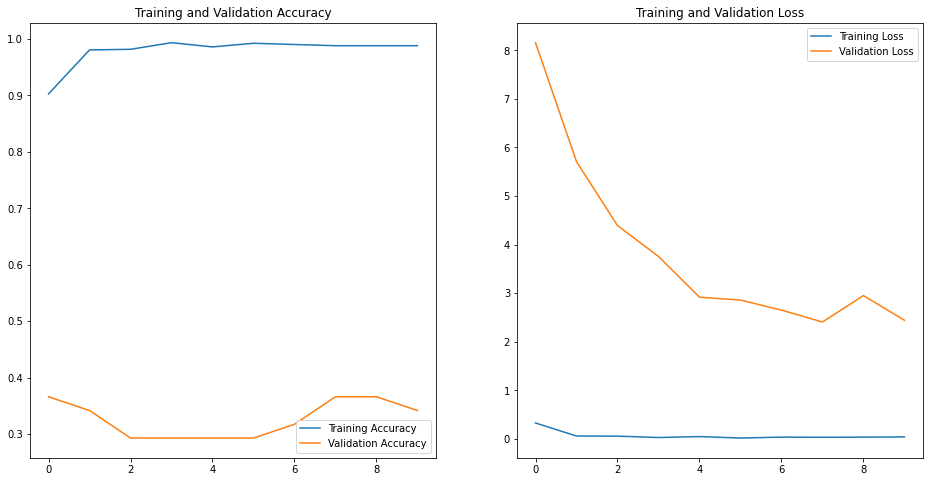

In [37]:
plot_results(r)

In [48]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 224, 224
img = image.load_img('/content/drive/MyDrive/dataset/mbway1.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model.predict(img)

array([[0.00394574, 0.15830453, 0.0065247 , 0.8312251 ]], dtype=float32)

In [42]:
label_map= (training_set.class_indices)
print(label_map)


{'cgd': 0, 'mbway': 1, 'novobanco': 2, 'prosegur': 3}
